In [2]:
import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation

plt.style.use("seaborn-v0_8")

rng_key = random.PRNGKey(123)

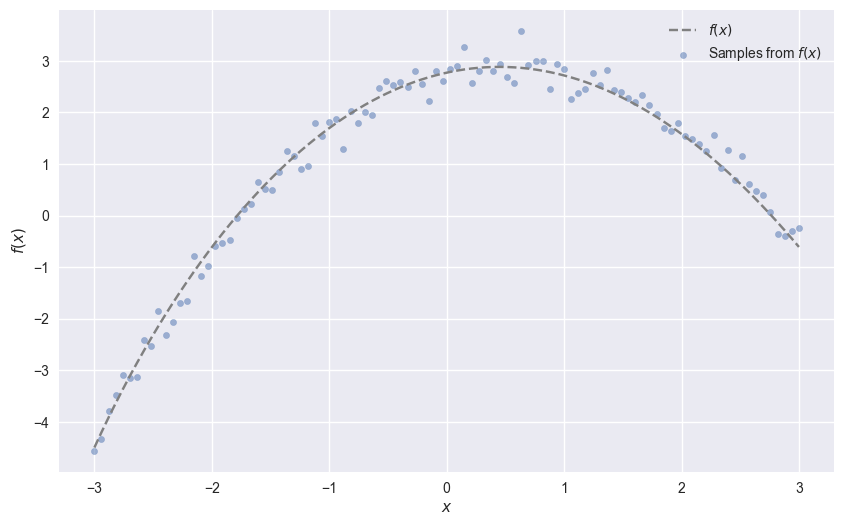

In [3]:
def some_function(x: float) -> float:
    assert np.all(-4 < x)
    return -0.5 * x**2 + 2 * np.log(x + 4)

def sample_from_some_function(x: float) -> float:
    return np.random.normal(some_function(x), 0.3)

x = np.linspace(-3, 3, 100)
y = some_function(x)
y_samples = np.array([sample_from_some_function(x) for x in x])

plt.figure(figsize=(10, 6))
plt.plot(x, y, c="gray", label=r"$f(x)$", linestyle="--")
plt.scatter(x, y_samples, label=r"Samples from $f(x)$", s=20, alpha=0.5)
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.legend()
plt.grid(True)
plt.show()


In [4]:
# squared exponential kernel with diagonal noise term
def kernel(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k


def model(X, Y):
    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))

    # compute kernel
    k = kernel(X, X, var, length, noise)

    # sample Y according to the standard gaussian process formula
    numpyro.sample("Y", dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k), obs=Y)
    
guide = AutoLaplaceApproximation(model)
optimizer = numpyro.optim.Adam(0.1)
elbo = Trace_ELBO()

In [11]:
# Initial dataset
x = np.array([-3, 0, 2])
y = sample_from_some_function(x)
X = jnp.array(x)
Y = jnp.array(y)

print(f"X = {X}")
print(f"Y = {Y}")

X = [-3  0  2]
Y = [-3.893145   2.4743886  1.3398407]


In [12]:
# Predictive function
@jax.jit
def predict(rng_key, X, Y, X_test, var, length, noise):
    k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
    k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
    k_XX = kernel(X, X, var, length, noise, include_noise=True)
    K_xx_inv = jnp.linalg.inv(k_XX)
    K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
    sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.0)) * jax.random.normal(
        rng_key, X_test.shape[:1]
    )
    mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y))
    return mean, mean + sigma_noise

In [13]:
# Run inference
svi = SVI(model, guide, optimizer, elbo, X=X, Y=Y)
rng_key, rng_key_ = random.split(rng_key)
svi_result = svi.run(rng_key_, 1000)
params = svi_result.params

rng_key, rng_key_ = random.split(rng_key)
samples = guide.sample_posterior(rng_key_, params, (1000,))

100%|██████████| 1000/1000 [00:00<00:00, 4275.53it/s, init loss: 17.2069, avg. loss [951-1000]: 16.9469]
/var/folders/4_/vrr8kzqn5b9dxsprxn13022m0000gn/T/ipykernel_85090/3207080454.py:8: UserWarning: Hessian of log posterior at the MAP point is singular. Posterior samples from AutoLaplaceApproxmiation will be constant (equal to the MAP point). Please consider using an AutoNormal guide.
  samples = guide.sample_posterior(rng_key_, params, (1000,))


In [14]:
# Sample functions from posterior 
rng_key, rng_key_ = random.split(rng_key)
keys = random.split(rng_key_, samples["kernel_var"].shape[0])
vars = samples["kernel_var"]
lengths = samples["kernel_length"]
noises = samples["kernel_noise"]

X_test = jnp.linspace(-3, 3, 100)
means, predictions = jax.vmap(
    lambda rng_key, var, length, noise: predict(
        rng_key, X, Y, X_test, var, length, noise
    )
)(keys, vars, lengths, noises)

mean_prediction = np.mean(means, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

In [17]:
# Q1. Sample an acquisition function from posterior
#a_sample = # A sampled acquisition function
#i_star = # Argmax of the acquisition function
#X_test_star = # The point that maximizes the acquisition function

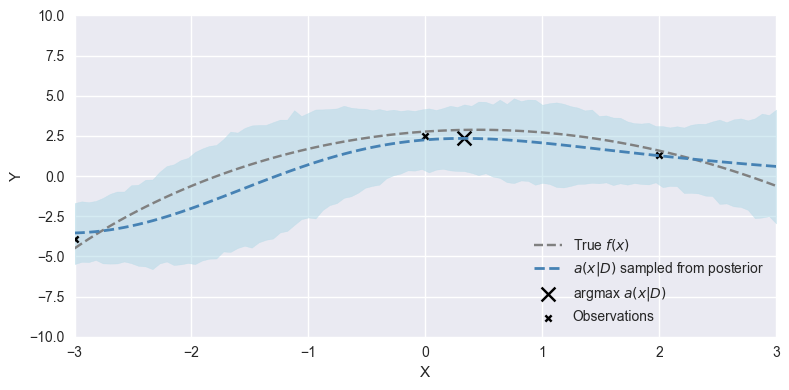

In [16]:
# True function
x = np.linspace(-3, 3, 100)
y = some_function(x)

# Plot the result
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

ax.fill_between(X_test, percentiles[0, :], percentiles[1, :], color="lightblue", alpha=0.5)
ax.plot(x, y, c="gray", label=r"True $f(x)$", linestyle="--")
ax.plot(X_test, a_sample, c="steelblue", ls="dashed", lw=2.0, label="$a(x|D)$ sampled from posterior")
ax.scatter(X_test_star, a_sample[i_star], c="k", marker="x", s=100, label="argmax $a(x|D)$")
ax.scatter(X, Y, c="k", marker="x", s=20, label="Observations")
ax.set_xlim([-3, 3])
ax.set_ylim([-10, 10])
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [ ]:
# Q2. Implement Bayesian optimization that sequentially decides 
# which point to sample next and finds the maximum of the function
